In [8]:
from matplotlib import pyplot as plt
from numpy.polynomial.hermite import Hermite
from math import factorial
from qutip import *
import numpy as np
from scipy import *
import imageio
from tqdm import tqdm
import os
from os.path import exists

In [9]:
#Funciones

def FuncionesOscilador(N,n,x):
    h=zeros(N)
    h[n]=1
    c=(1/sqrt(2**(n)*factorial(n)))*pow(1/np.pi,0.25)
    return c*exp(-0.5*x**2)*Hermite(h)(x)

def VectorAHermite(N,v,x):
    result=0
    for n in range(len(v)):
        result+=v[n]*FuncionesOscilador(N,n,x)
    return result

def EsferaBloch(ρ):
    sx=(sigmax()*ρ).tr()
    sy=(sigmay()*ρ).tr()
    sz=(sigmaz()*ρ).tr()
    return [sx, sy, sz]

def VectorAPunto(v):
    x=[j[0] for j in v]
    y=[j[1] for j in v]
    z=[j[2] for j in v]
    return [x, y, z]

In [10]:
#Número de polinomios de Hermite 
Nc=5

#Spin y dimensión de cada subespacio cuántico
S=0.5
Nq=int(2*S+1)

#Operadores identidad
Ic=qeye(Nc)
Iq=qeye(Nq)

In [11]:
#Definición de coordenadas y momentos clásicos
a = np.zeros((Nc,Nc)) #Operador destrucción
aa = np.zeros((Nc,Nc)) #Operador creación
for i in range(Nc-1):
    a[i][i+1]=math.sqrt(i+1)
    aa[i+1][i]=math.sqrt(i+1)

aaq=tensor(Qobj(aa),Ic)
aap=tensor(Ic,Qobj(aa))
aq=tensor(Qobj(a),Ic)
ap=tensor(Ic,Qobj(a))

q=1/np.sqrt(2)*(aq+aaq)
piq=-1j*1/np.sqrt(2)*(aaq-aq)
p=1/np.sqrt(2)*(ap+aap)
pip=-1j*1/np.sqrt(2)*(aap-ap)


In [12]:
#Momento angular cuántico

S2q=S*(S+1)*qeye(Nq)
mz=np.zeros(Nq)
for j in range(Nq):
    mz[j]=-S+j

Sp_aux=zeros((Nq,Nq))
Sm_aux=zeros((Nq,Nq))
Sz_aux=zeros((Nq,Nq))

for k in range(Nq):
    if k!=Nq-1:
        Sm_aux[k][k+1]=np.sqrt(S*(S+1)-mz[k+1]*(mz[k+1]-1))
        Sp_aux[k+1][k]=np.sqrt(S*(S+1)-mz[k]*(mz[k]+1))
    Sz_aux[k][k]=mz[k]
    
Sp=Qobj(Sp_aux)
Sm=Qobj(Sm_aux)
Sz=Qobj(Sz_aux)


S2=tensor(S2q,Iq)+tensor(Iq,S2q)+2*tensor(Sz,Sz)+tensor(Sp,Sm)+tensor(Sm,Sp)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_10588\2515079388.py:8: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  Sp_aux=zeros((Nq,Nq))
C:\Users\Usuario\AppData\Local\Temp\ipykernel_10588\2515079388.py:9: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  Sm_aux=zeros((Nq,Nq))
C:\Users\Usuario\AppData\Local\Temp\ipykernel_10588\2515079388.py:10: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  Sz_aux=zeros((Nq,Nq))


In [13]:
#Hamiltoniano
Hc=-1j/2*((aq+aaq)*(ap-aap)-(ap+aap)*(aq-aaq))
Hq=tensor(sigmax(),Iq)+tensor(Iq,sigmax())
Hcq=tensor(q+p,tensor(sigmaz(),Iq)+tensor(Iq,sigmaz()))

H=tensor(Hc,Iq,Iq)+tensor(Ic,Ic,Hq)+Hcq
#H=tensor(Hc,Iq,Iq)

#Operadores de Krauss
V0c=q+piq-pip

V0=tensor(V0c,S2)


In [14]:
#PARTE CLÁSICA
ϕc=tensor(basis(Nc,0),basis(Nc,1))

#PARTE CUÁNTICA
#Singlete
ϕsq=tensor(basis(Nq,1),basis(Nq,0))-tensor(basis(Nq,0),basis(Nq,1))

#Triplete
ϕtq=tensor(basis(Nq,1),basis(Nq,1))

#Total
ϕs=(tensor(ϕc,ϕsq)).unit()
ϕt=(tensor(ϕc,ϕtq)).unit()

ρs=ϕs*ϕs.dag()
ρt=ϕt*ϕt.dag()
ρc=ϕc*ϕc.dag()

In [15]:
#Simulaciones
T=5 #Tiempo de simulación
pasos=30 #Número de pasos temporales
time=linspace(0,T,pasos)

#Evolución híbrida unitaria
EvolucionUnitariaSinglete=mesolve(H,ρs,time,progress_bar=True,options=Options(nsteps=500000))
EvolucionUnitariaTriplete=mesolve(H,ρt,time,progress_bar=True,options=Options(nsteps=500000))

#Evolución híbrida Lindbladiana
EvolucionLindbladianaSinglete=mesolve(H,ρs,time,c_ops=[V0],progress_bar=True,options=Options(nsteps=500000))
EvolucionLindbladianaTriplete=mesolve(H,ρt,time,c_ops=[V0],progress_bar=True,options=Options(nsteps=500000))


#Evolución clásica Linbladiana
EvolucionClasica=mesolve(Hc,ρc,time,c_ops=[V0c],progress_bar=True)

10.0%. Run time:   0.03s. Est. time left: 00:00:00:00
20.0%. Run time:   0.03s. Est. time left: 00:00:00:00
30.0%. Run time:   0.04s. Est. time left: 00:00:00:00
40.0%. Run time:   0.06s. Est. time left: 00:00:00:00
50.0%. Run time:   0.07s. Est. time left: 00:00:00:00
60.0%. Run time:   0.08s. Est. time left: 00:00:00:00
70.0%. Run time:   0.10s. Est. time left: 00:00:00:00
80.0%. Run time:   0.11s. Est. time left: 00:00:00:00
90.0%. Run time:   0.12s. Est. time left: 00:00:00:00
Total run time:   0.14s
10.0%. Run time:   0.04s. Est. time left: 00:00:00:00


C:\Users\Usuario\AppData\Local\Temp\ipykernel_10588\2170090400.py:4: DeprecationWarning: scipy.linspace is deprecated and will be removed in SciPy 2.0.0, use numpy.linspace instead
  time=linspace(0,T,pasos)


20.0%. Run time:   0.08s. Est. time left: 00:00:00:00
30.0%. Run time:   0.12s. Est. time left: 00:00:00:00
40.0%. Run time:   0.17s. Est. time left: 00:00:00:00
50.0%. Run time:   0.22s. Est. time left: 00:00:00:00
60.0%. Run time:   0.27s. Est. time left: 00:00:00:00
70.0%. Run time:   0.30s. Est. time left: 00:00:00:00
80.0%. Run time:   0.35s. Est. time left: 00:00:00:00
90.0%. Run time:   0.42s. Est. time left: 00:00:00:00
Total run time:   0.45s
10.0%. Run time:   0.10s. Est. time left: 00:00:00:00
20.0%. Run time:   0.45s. Est. time left: 00:00:00:01
30.0%. Run time:   0.84s. Est. time left: 00:00:00:01
40.0%. Run time:   1.26s. Est. time left: 00:00:00:01
50.0%. Run time:   1.71s. Est. time left: 00:00:00:01
60.0%. Run time:   2.11s. Est. time left: 00:00:00:01
70.0%. Run time:   2.46s. Est. time left: 00:00:00:01
80.0%. Run time:   2.81s. Est. time left: 00:00:00:00
90.0%. Run time:   3.06s. Est. time left: 00:00:00:00
Total run time:   3.26s
10.0%. Run time:   0.43s. Est. tim

In [16]:
#Evolución híbrida Lindbladiana para el singlete
#Matrices
EstadosLindbladianaSinglete=[EvolucionLindbladianaSinglete.states[t] for t in range(len(time))]
ρcLindbladianaSinglete=[EstadosLindbladianaSinglete[i].ptrace([0,1]) for i in range(len(time))]
ρ2cLindbladianaSinglete=[ρcLindbladianaSinglete[i]*ρcLindbladianaSinglete[i] for i in range(len(time))]
ρqLindbladianaSinglete=[EstadosLindbladianaSinglete[i].ptrace([2]) for i in range(len(time))]
ρq1LindbladianaSinglete=[EstadosLindbladianaSinglete[i].ptrace([2,3]) for i in range(len(time))]
ρq2LindbladianaSinglete=[EstadosLindbladianaSinglete[i].ptrace([3]) for i in range(len(time))]
#Trazas
TrazaLindbladianaSinglete=[(EstadosLindbladianaSinglete[i].ptrace([2,3])).tr() for i in range(len(time))]
ρcTrazaLindbladianaSinglete=[ρcLindbladianaSinglete[t].full().trace() for t in range(len(time))]
ρ2cTrazaLindbladianaSinglete=[ρ2cLindbladianaSinglete[t].full().trace() for t in range(len(time))]
#Entropías
EntropiaLindbladianaSinglete=[entropy_vn(rho, base=np.e, sparse=False) for rho in ρcLindbladianaSinglete]
EntropiaTotalLindbladianaSinglete=[entropy_vn(rho, base=np.e, sparse=False) for rho in EstadosLindbladianaSinglete]
EntropiaCuanticaLindbladianaSinglete=[entropy_vn(rho, base=np.e, sparse=False) for rho in ρqLindbladianaSinglete]



In [19]:
#Evolución híbrida Lindbladiana para el triplete
#Matrices
EstadosLindbladianaTriplete=[EvolucionLindbladianaTriplete.states[t] for t in range(len(time))]
ρcLindbladianaTriplete=[EstadosLindbladianaTriplete[i].ptrace([0,1]) for i in range(len(time))]
ρ2cLindbladianaTriplete=[ρcLindbladianaTriplete[i]*ρcLindbladianaTriplete[i] for i in range(len(time))]
ρqLindbladianaTriplete=[EstadosLindbladianaTriplete[i].ptrace([2,3]) for i in range(len(time))]
ρq1LindbladianaTriplete=[EstadosLindbladianaTriplete[i].ptrace([2]) for i in range(len(time))]
ρq2LindbladianaTriplete=[EstadosLindbladianaTriplete[i].ptrace([3]) for i in range(len(time))]
#Trazas
TrazaLindbladianaTriplete=[(EstadosLindbladianaTriplete[i].ptrace([2,3])).tr() for i in range(len(time))]
ρcTrazaLindbladianaTriplete=[ρcLindbladianaTriplete[t].full().trace() for t in range(len(time))]
ρ2cTrazaLindbladianaTriplete=[ρ2cLindbladianaTriplete[t].full().trace() for t in range(len(time))]
#Entropías
EntropiaLindbladianaTriplete=[entropy_vn(rho, base=np.e, sparse=False) for rho in ρcLindbladianaTriplete]
EntropiaTotalLindbladianaTriplete=[entropy_vn(rho, base=np.e, sparse=False) for rho in EstadosLindbladianaTriplete]
EntropiaCuanticaLindbladianaTriplete=[entropy_vn(rho, base=np.e, sparse=False) for rho in ρqLindbladianaTriplete]



In [20]:
#Evolución híbrida unitaria para el singlete
#Matrices
EstadosUnitariaSinglete=[EvolucionUnitariaSinglete.states[t] for t in range(len(time))]
ρcUnitariaSinglete=[EstadosUnitariaSinglete[i].ptrace([0,1]) for i in range(len(time))]
ρ2cUnitariaSinglete=[ρcUnitariaSinglete[i]*ρcUnitariaSinglete[i] for i in range(len(time))]
ρqUnitariaSinglete=[EstadosUnitariaSinglete[i].ptrace([2,3]) for i in range(len(time))]
ρq1UnitariaSinglete=[EstadosUnitariaSinglete[i].ptrace([2]) for i in range(len(time))]
ρq2UnitariaSinglete=[EstadosUnitariaSinglete[i].ptrace([3]) for i in range(len(time))]
#Trazas
TrazaUnitariaSinglete=[(EstadosUnitariaSinglete[i].ptrace([2,3])).tr() for i in range(len(time))]
ρcTrazaUnitariaSinglete=[ρcUnitariaSinglete[t].full().trace() for t in range(len(time))]
ρ2cTrazaUnitariaSinglete=[ρ2cUnitariaSinglete[t].full().trace() for t in range(len(time))]
#Entropías
EntropiaUnitariaSinglete=[entropy_vn(rho, base=np.e, sparse=False) for rho in ρcUnitariaSinglete]
EntropiaTotalUnitariaSinglete=[entropy_vn(rho, base=np.e, sparse=False) for rho in EstadosUnitariaSinglete]
EntropiaCuanticaUnitariaSinglete=[entropy_vn(rho, base=np.e, sparse=False) for rho in ρqUnitariaSinglete]


In [21]:
#Evolución híbrida unitaria para el triplete
#Matrices
EstadosUnitariaTriplete=[EvolucionUnitariaTriplete.states[t] for t in range(len(time))]
ρcUnitariaTriplete=[EstadosUnitariaTriplete[i].ptrace([0,1]) for i in range(len(time))]
ρ2cUnitariaTriplete=[ρcUnitariaTriplete[i]*ρcUnitariaTriplete[i] for i in range(len(time))]
ρqUnitariaTriplete=[EstadosUnitariaTriplete[i].ptrace([2,3]) for i in range(len(time))]
ρq1UnitariaTriplete=[EstadosUnitariaTriplete[i].ptrace([2]) for i in range(len(time))]
ρq2UnitariaTriplete=[EstadosUnitariaTriplete[i].ptrace([3]) for i in range(len(time))]
#Trazas
TrazaUnitariaTriplete=[(EstadosUnitariaTriplete[i].ptrace([2,3])).tr() for i in range(len(time))]
ρcTrazaUnitariaTriplete=[ρcUnitariaTriplete[t].full().trace() for t in range(len(time))]
ρ2cTrazaUnitariaTriplete=[ρ2cUnitariaTriplete[t].full().trace() for t in range(len(time))]
#Entropías
EntropiaUnitariaTriplete=[entropy_vn(rho, base=np.e, sparse=False) for rho in ρcUnitariaTriplete]
EntropiaTotalUnitariaTriplete=[entropy_vn(rho, base=np.e, sparse=False) for rho in EstadosUnitariaTriplete]
EntropiaCuanticaUnitariaTriplete=[entropy_vn(rho, base=np.e, sparse=False) for rho in ρqUnitariaTriplete]


In [22]:
#Evolución clásica Lindbladiana
#Matrices
EstadosClasica=[EvolucionClasica.states[t] for t in range(len(time))]
Estados2Clasica=[EstadosClasica[i]*EstadosClasica[i] for i in range(len(time))]
#Trazas
TrazaClasica=[(EstadosClasica[i]).tr() for i in range(len(time))]
Traza2Clasica=[(Estados2Clasica[i]).tr() for i in range(len(time))]
#Entropías
EntropiaClasica=[entropy_vn(rho, base=np.e, sparse=False) for rho in EstadosClasica]

C:\Users\Usuario\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\Usuario\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\Usuario\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\Usuario\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\Usuario\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


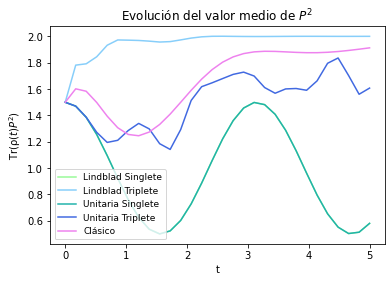

In [31]:
#Valor medio de los operadores

A=tensor(p*p,Iq,Iq)
Ac=p*p

ALindbladianaSinglete=np.zeros(len(time),dtype=complex)
AUnitariaSinglete=np.zeros(len(time),dtype=complex)
ALindbladianaTriplete=np.zeros(len(time),dtype=complex)
AUnitariaTriplete=np.zeros(len(time),dtype=complex)
AClasica=np.zeros(len(time),dtype=complex)


for t in range(len(time)):
    ALindbladianaSinglete[t]=((EstadosLindbladianaSinglete[t]*A).ptrace([0,1])).tr()
    AUnitariaSinglete[t]=((EstadosUnitariaSinglete[t]*A).ptrace([0,1])).tr()
    ALindbladianaTriplete[t]=((EstadosLindbladianaTriplete[t]*A).ptrace([0,1])).tr()
    AUnitariaTriplete[t]=((EstadosUnitariaTriplete[t]*A).ptrace([0,1])).tr()
    AClasica[t]=((EstadosClasica[t]*Ac)).tr()

fig, ax = plt.subplots()
ax.plot(time,ALindbladianaSinglete,color='palegreen',label='Lindblad Singlete')
ax.plot(time,ALindbladianaTriplete,color='lightskyblue',label='Lindblad Triplete')

ax.plot(time,AUnitariaSinglete,color='lightseagreen',label='Unitaria Singlete')
ax.plot(time,AUnitariaTriplete,color='royalblue',label='Unitaria Triplete')

ax.plot(time,AClasica,color='violet',label='Clásico')

ax.set_xlabel('t')
ax.set_ylabel('Tr(ρ$(t)P^2$)')
ax.set_title('Evolución del valor medio de $P^2$')
ax.legend(loc='lower left',ncol=1,fontsize=9)

#plt.savefig("./Graficas/DinamicaOperadores/P2")
plt.show()


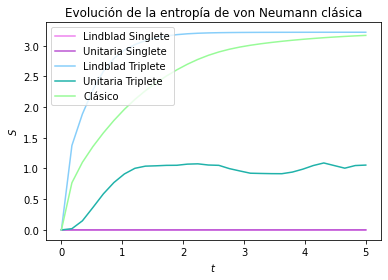

In [29]:
#Entropía clásica

fig, ax = plt.subplots()

ax.plot(time,EntropiaLindbladianaSinglete,label="Lindblad Singlete",color='violet')
ax.plot(time,EntropiaUnitariaSinglete,label="Unitaria Singlete",color='mediumorchid')

ax.plot(time,EntropiaLindbladianaTriplete,label="Lindblad Triplete",color='lightskyblue')
ax.plot(time,EntropiaUnitariaTriplete,label="Unitaria Triplete",color='lightseagreen')

ax.plot(time,EntropiaClasica,label="Clásico",color='palegreen')

ax.set_xlabel('$t$')
ax.set_ylabel('$S$')
ax.set_title('Evolución de la entropía de von Neumann clásica')
ax.legend(loc='upper left',fontsize=10)

#plt.savefig("./Graficas/Ejemplo3/Entropia_Hh")
plt.show()



C:\Users\Usuario\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\Usuario\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\Usuario\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\Usuario\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


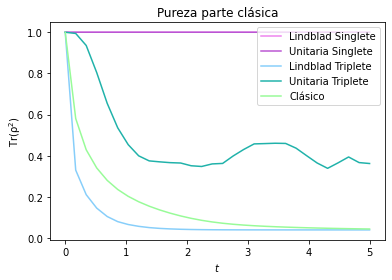

In [32]:
#Pureza clásica

fig, ax = plt.subplots()

ax.plot(time,ρ2cTrazaLindbladianaSinglete,label="Lindblad Singlete",color='violet')
ax.plot(time,ρ2cTrazaUnitariaSinglete,label="Unitaria Singlete",color='mediumorchid')
ax.plot(time,ρ2cTrazaLindbladianaTriplete,label="Lindblad Triplete",color='lightskyblue')
ax.plot(time,ρ2cTrazaUnitariaTriplete,label="Unitaria Triplete",color='lightseagreen')

ax.plot(time,Traza2Clasica,label="Clásico",color='palegreen')

ax.set_xlabel("$t$")
ax.set_ylabel("Tr(ρ$^2$)")
ax.set_title('Pureza parte clásica')
ax.legend(loc='upper right')

#plt.savefig("./Graficas/Ejemplo3/Pureza_Hh")
plt.show()

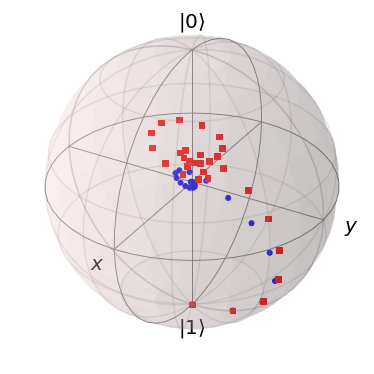

In [34]:
#Evolución del estado cuántico
b=Bloch()

b.add_points(VectorAPunto([EsferaBloch(j) for j in ρq1LindbladianaTriplete]))
b.add_points(VectorAPunto([EsferaBloch(j) for j in ρq1UnitariaTriplete]))

b.show()
#b.save("./Graficas/ejemplo3/VariosKrauss")


  0%|          | 0/30 [00:00<?, ?it/s]C:\Users\Usuario\AppData\Local\Temp\ipykernel_10588\1193750031.py:6: DeprecationWarning: scipy.linspace is deprecated and will be removed in SciPy 2.0.0, use numpy.linspace instead
  x = linspace(-2,2,50)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_10588\1193750031.py:7: DeprecationWarning: scipy.linspace is deprecated and will be removed in SciPy 2.0.0, use numpy.linspace instead
  y = linspace(-2,2,50)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_10588\1193750031.py:10: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  z=zeros((50,50))
C:\Users\Usuario\AppData\Local\Temp\ipykernel_10588\3571103421.py:4: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  h=zeros(N)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_10588\3571103421.py:6: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scima

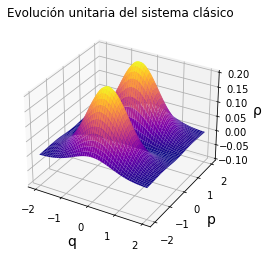

  3%|▎         | 1/30 [00:01<00:29,  1.02s/it]

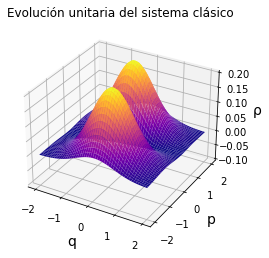

  7%|▋         | 2/30 [00:01<00:25,  1.08it/s]

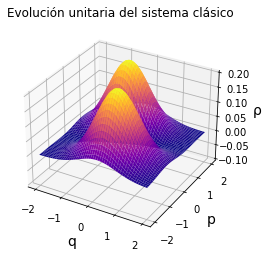

 10%|█         | 3/30 [00:02<00:21,  1.27it/s]

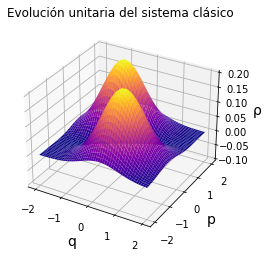

 13%|█▎        | 4/30 [00:03<00:20,  1.25it/s]

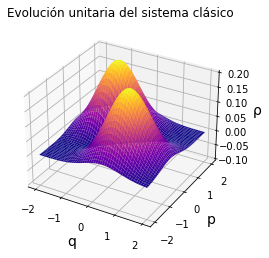

 17%|█▋        | 5/30 [00:04<00:22,  1.12it/s]

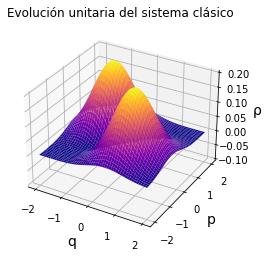

 20%|██        | 6/30 [00:05<00:20,  1.18it/s]

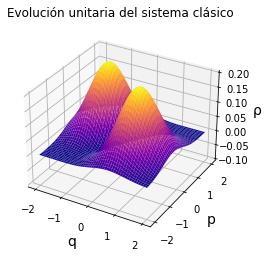

 23%|██▎       | 7/30 [00:06<00:20,  1.10it/s]

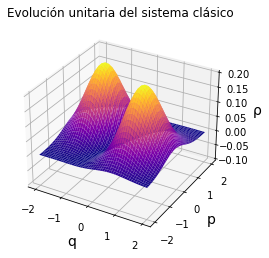

 27%|██▋       | 8/30 [00:06<00:18,  1.16it/s]

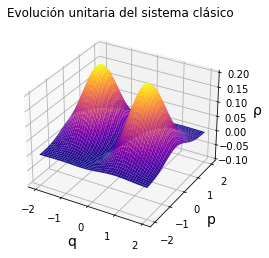

 30%|███       | 9/30 [00:07<00:17,  1.19it/s]

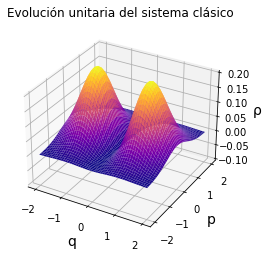

 33%|███▎      | 10/30 [00:08<00:16,  1.19it/s]

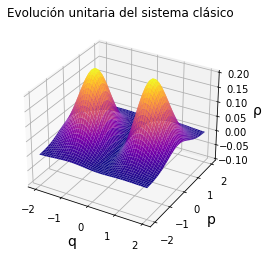

 37%|███▋      | 11/30 [00:09<00:14,  1.28it/s]

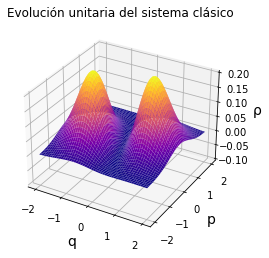

 40%|████      | 12/30 [00:09<00:13,  1.30it/s]

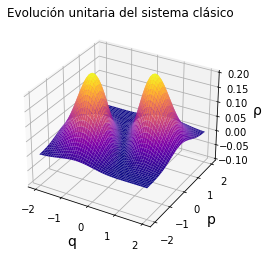

 43%|████▎     | 13/30 [00:10<00:12,  1.34it/s]

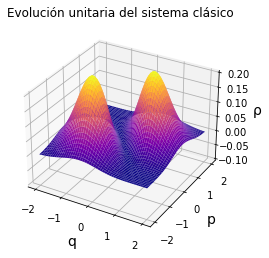

 47%|████▋     | 14/30 [00:11<00:11,  1.41it/s]

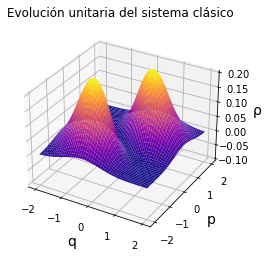

 50%|█████     | 15/30 [00:12<00:11,  1.34it/s]

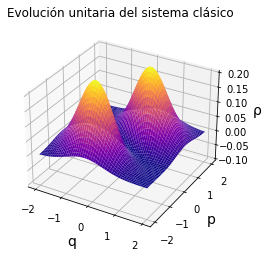

 53%|█████▎    | 16/30 [00:12<00:10,  1.40it/s]

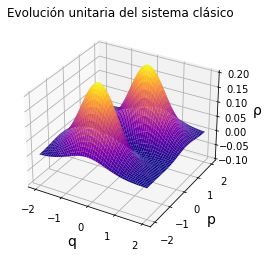

 57%|█████▋    | 17/30 [00:13<00:09,  1.33it/s]

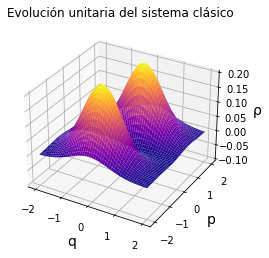

 60%|██████    | 18/30 [00:14<00:09,  1.29it/s]

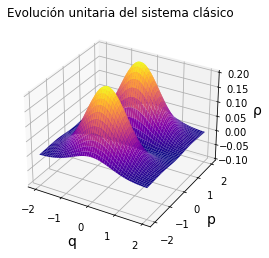

 63%|██████▎   | 19/30 [00:15<00:08,  1.26it/s]

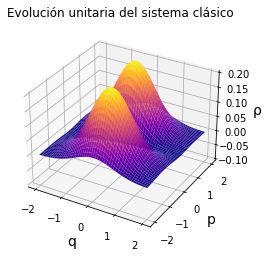

 67%|██████▋   | 20/30 [00:16<00:07,  1.26it/s]

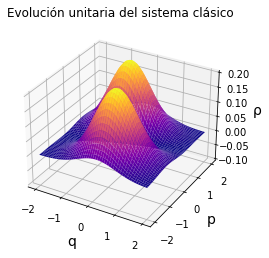

 70%|███████   | 21/30 [00:16<00:07,  1.21it/s]

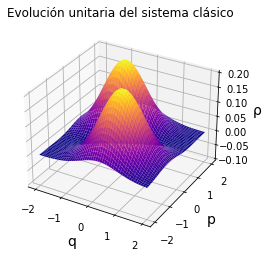

 73%|███████▎  | 22/30 [00:17<00:06,  1.23it/s]

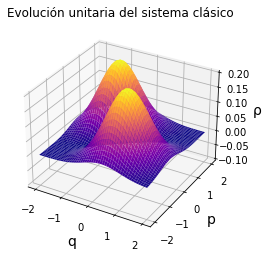

 77%|███████▋  | 23/30 [00:18<00:05,  1.27it/s]

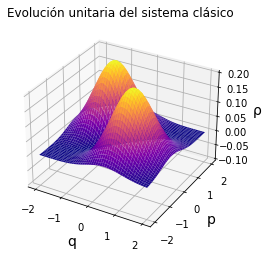

 80%|████████  | 24/30 [00:19<00:04,  1.20it/s]

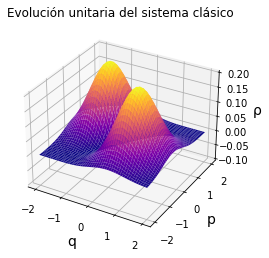

 83%|████████▎ | 25/30 [00:20<00:04,  1.14it/s]

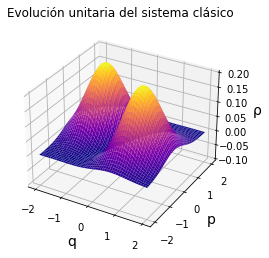

 87%|████████▋ | 26/30 [00:21<00:03,  1.22it/s]

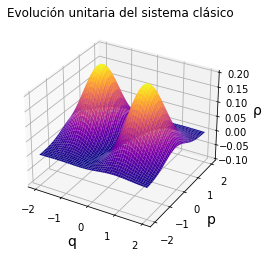

 90%|█████████ | 27/30 [00:21<00:02,  1.25it/s]

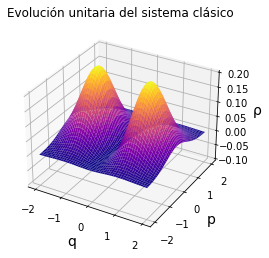

 93%|█████████▎| 28/30 [00:22<00:01,  1.32it/s]

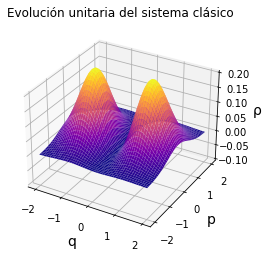

 97%|█████████▋| 29/30 [00:23<00:00,  1.27it/s]

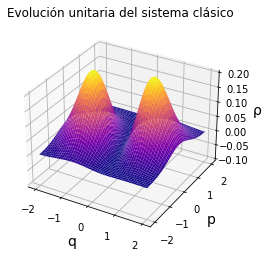

100%|██████████| 30/30 [00:24<00:00,  1.24it/s]


In [35]:
#Representación 3D de la dinámica 

matriz3d=[]

for t in tqdm(range(0,30,1)):
    x = linspace(-2,2,50)
    y = linspace(-2,2,50)
    x, y = np.meshgrid(x, y)
    
    z=zeros((50,50))
    rho=0
    
    for i in range(Nc):
        for j in range(Nc):
            for k in range(Nc):
                for l in range(Nc):
                    rho+=ρcUnitariaSinglete[t].full()[Nc*i+j][Nc*k+l]*FuncionesOscilador(Nc,i,x)*FuncionesOscilador(Nc,j,y)*FuncionesOscilador(Nc,k,x)*FuncionesOscilador(Nc,l,y)
    for X in range(50):
        for Y in range(50):
            z[X][Y]=rho[X][Y]
    matriz3d.append(z)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(x, y, z, cmap='plasma')
    ax.set_xlabel('q', fontsize=14)
    ax.set_ylabel('p', fontsize=14)
    ax.set_zlabel('ρ', fontsize=14)
    ax.set_title('Evolución unitaria del sistema clásico')
    ax.set_zlim(-0.1,0.2)
    if t==0:
        plt.savefig(f'./Graficas/3D/Estado_inicial')
    if t==14:
        plt.savefig(f'./Graficas/3D/Estado_t1')
    plt.show()

In [36]:
import io

In [37]:
def generar_grafico_3d(i):
    x = linspace(-2,2,50)
    y = linspace(-2,2,50)
    x, y = np.meshgrid(x, y)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(x, y, matriz3d[i], cmap='plasma')
    ax.set_xlabel('q', fontsize=14)
    ax.set_ylabel('p', fontsize=14)
    ax.set_zlabel('ρ', fontsize=14)
    ax.set_title('Evolución unitaria del sistema clásico')
    ax.set_zlim(-0.1,0.2)
    
    
    img_buffer = io.BytesIO()
    plt.savefig(img_buffer, format='png')
    
    plt.close(fig)
    
    return img_buffer.getvalue()


In [18]:
frames = [generar_grafico_3d(i) for i in range(30)]

filename = 'SingleteUnitario.gif'
imageio.mimsave(filename, [imageio.imread(io.BytesIO(frame)) for frame in frames], duration=0.1)

plt.show() 


C:\Users\Usuario\AppData\Local\Temp\ipykernel_9912\2141452095.py:2: DeprecationWarning: scipy.linspace is deprecated and will be removed in SciPy 2.0.0, use numpy.linspace instead
  x = linspace(-2,2,50)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_9912\2141452095.py:3: DeprecationWarning: scipy.linspace is deprecated and will be removed in SciPy 2.0.0, use numpy.linspace instead
  y = linspace(-2,2,50)
